# Reproducing Porto Seguro Kaggle-Winning Model
This notebook has been written specially to run in a Google Colab environment with its hardware limitations. If you have a more powerful system, you should try to modify this notebook to make things run exactly as specified by the Kaggle champion!
## Installing Libraries and Downloading Data
In Colab, you'll only need to install dfencoder. Dependencies are already installed. <br><br>
I've placed the data on github for easy access in this example.

In [1]:
!pip install dfencoder

In [2]:
!wget https://github.com/AlliedToasters/public_data/raw/master/test.7z
!wget https://github.com/AlliedToasters/public_data/raw/master/train.7z

--2019-06-26 23:28:53--  https://github.com/AlliedToasters/public_data/raw/master/test.7z
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlliedToasters/public_data/master/test.7z [following]
--2019-06-26 23:28:53--  https://raw.githubusercontent.com/AlliedToasters/public_data/master/test.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25235310 (24M) [application/octet-stream]
Saving to: ‘test.7z’

test.7z             100%[===================>]  24.07M   148MB/s    in 0.2s    

2019-06-26 23:28:54 (148 MB/s) - ‘test.7z’ saved [25235310/25235310]

--2019-06-26 23:28:55--  https://github.com/All

In [3]:
#unzip the data
!7z x test.7z
!7z x train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 25235310 bytes (25 MiB)

Extracting archive: test.7z
--
Path = test.7z
Type = 7z
Physical Size = 25235310
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      9% - test.csv                19% - test.csv                29% - test.csv                41% - test.csv                53% - test.csv                62% - test.csv                73% - test.csv                82% - test.csv                92% - test.csv               Ever

In [0]:
#import libraries and load data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
from dfencoder import AutoEncoder

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Processing
If you read the solution carefully, you'll notice a few odd things:
 - Michael one-hot encoded the categorical variables and then treated them as *numeric* variables. That is, he used MSE as a loss during the DAE representation learning phase.
 - He left the categorical columns in the dataset and apparently treated them as numeric as well, applying the same scaling he did to other numeric columns (except the one-hot columns).<br><br>


 These preprocessing steps will reproduce Michael's.

In [0]:
#generate lists of column names so we can treat them differently.
to_remove = ['id']
binary = []
cats = []

for col in train.columns:
    if 'calc' in col:
        to_remove.append(col)
    elif 'bin' in col:
        binary.append(col)
    elif 'cat' in col:
        cats.append(col)

In [0]:
#drop undesired columns.
X_train = train.drop(columns=to_remove+['target'])
Y_train = train['target']

In [0]:
X_test = test.drop(columns=to_remove)

In [0]:
#do our one-hot encoding, naming new columns.
for cat in cats:
    ohe = pd.get_dummies(X_test[cat])
    ohe_columns = [cat + "_ohe_" + str(i) for i in ohe.columns]
    ohe.columns = ohe_columns
    X_test = pd.concat([X_test, ohe], axis=1)

    ohe = pd.get_dummies(X_train[cat])
    ohe.columns = ohe_columns
    X_train = pd.concat([X_train, ohe], axis=1)

    binary += ohe_columns

In [0]:
#set all column types to numeric
for col in X_train.columns:
    if col in binary:
        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)
  

In [10]:
#our dataframe should have 221 columns, all numeric.
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_ind_02_cat_ohe_-1,ps_ind_02_cat_ohe_1,ps_ind_02_cat_ohe_2,...,ps_car_11_cat_ohe_65,ps_car_11_cat_ohe_66,ps_car_11_cat_ohe_67,ps_car_11_cat_ohe_68,ps_car_11_cat_ohe_69,ps_car_11_cat_ohe_70,ps_car_11_cat_ohe_71,ps_car_11_cat_ohe_72,ps_car_11_cat_ohe_73,ps_car_11_cat_ohe_74,ps_car_11_cat_ohe_75,ps_car_11_cat_ohe_76,ps_car_11_cat_ohe_77,ps_car_11_cat_ohe_78,ps_car_11_cat_ohe_79,ps_car_11_cat_ohe_80,ps_car_11_cat_ohe_81,ps_car_11_cat_ohe_82,ps_car_11_cat_ohe_83,ps_car_11_cat_ohe_84,ps_car_11_cat_ohe_85,ps_car_11_cat_ohe_86,ps_car_11_cat_ohe_87,ps_car_11_cat_ohe_88,ps_car_11_cat_ohe_89,ps_car_11_cat_ohe_90,ps_car_11_cat_ohe_91,ps_car_11_cat_ohe_92,ps_car_11_cat_ohe_93,ps_car_11_cat_ohe_94,ps_car_11_cat_ohe_95,ps_car_11_cat_ohe_96,ps_car_11_cat_ohe_97,ps_car_11_cat_ohe_98,ps_car_11_cat_ohe_99,ps_car_11_cat_ohe_100,ps_car_11_cat_ohe_101,ps_car_11_cat_ohe_102,ps_car_11_cat_ohe_103,ps_car_11_cat_ohe_104
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#dfencoder allows us to specify scaling behavior per-feature;
#this dictionary will specify not to scale one-hot encoded features.
scaler_spec = {ft:None for ft in binary}

# Hardware Limitations of Colab
Unfortunately, the Google Colab environment does not have enough memory to hold both the train and test sets as expanded numeric dataframes.  Michael's system has 32 GB of memory, while we only have < 13 GB here.<br><br>
For this reason, we'll only train our DAE on the train set, reserving a small sample of the test set for validation.

In [0]:
#validation sample
X_val = X_test.sample(frac=.01)

In [13]:
#save the encoded test set for later
X_test.to_hdf('X_test.h5', key='stage', mode='w')



#delete references to memory-consuming data
import gc

del train
del test
del X_test

#remove objects from memory
gc.collect()

36

# Building the DAE
We can follow Michael's description of his model to the letter. From the write-up:<br>
![](https://raw.githubusercontent.com/AlliedToasters/dfencoder/master/demo_data/dae_arch.png?raw=true)<br><br>
In dfencoder, this translates to:

In [0]:
encoder = AutoEncoder(
    #input/output layers are implicit, so just these three...
    encoder_layers=[1500, 1500, 1500],
    decoder_layers=[],
    lr=2.8e-3,
    batch_size=128,
    activation='relu',
    lr_decay=.995,
    #here's your swap noise
    swap_p=.2,
    scaler=scaler_spec,
    optimizer='sgd',
    verbose=False,
    logger='ipynb'
)

# Fitting
Running 1000 epochs as specified takes a long time. It took Michael 5 hours, and this appears to take longer. Looks like we need to optimize the library. To be fair, Michael did everything in a compiled program in C++ ; in python we're carrying around a bunch of extra overhead. But, if you have the hardware and the patience, you can do it!

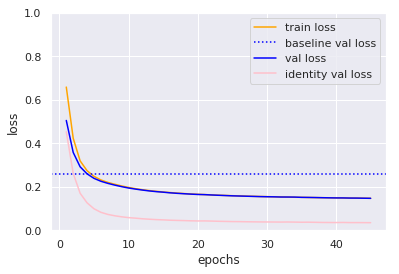

In [15]:
encoder.fit(X_train, val=X_val, epochs=200)

# Classifier Model
Creating the classifier model... From the write-up:<br>
![](https://github.com/AlliedToasters/dfencoder/raw/master/demo_data/nn_arch.png?raw=true)<br><br>
We can just whip this model up using pytorch (some ambiguity about "regL2" vs weight decay, possibly a factor of 2 error?  See [this article](https://bbabenko.github.io/weight-decay/). I would double the parameter but weight decay of .1 seems really high...):

In [0]:
import torch

class ClassifierModel(torch.nn.Module):
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(4500, 1000)
        self.dropout = torch.nn.Dropout(.5)
        self.dense1 = torch.nn.Linear(1000, 1000)
        self.dense2 = torch.nn.Linear(1000, 1000)
        self.output = torch.nn.Linear(1000, 1)
    
    def forward(self, x):
        x = self.input_dropout(x)

        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.dense1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.dense2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel()

In [0]:
optim = torch.optim.SGD(
    classifier.parameters(),
    lr=1e-4,
    weight_decay=.05,
    
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .995)

loss = torch.nn.modules.loss.BCELoss()

In [0]:
classifier = classifier.to("cuda:0")

Saving memory has been a headache in colab... These calls free up RAM and GPU memory.

In [19]:
gc.collect()

22543

In [0]:
torch.cuda.empty_cache()

# Training
To speed things up, we can compute the deep stack features in big batches in advance. However, with our lack of memory, we can't do this all at once. To work around this, we'll split the data into thirds, computing latent features in "megabatches" during training. This seems to get the job done pretty quickly.

In [21]:
import tqdm
from IPython.display import clear_output

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt
  
batch_size = 128
n_updates = (len(X_train)//batch_size) + 1

n_megabatches = 3
n_epochs = 150

n_rows = len(X_train)

res = n_rows/n_megabatches
batches_per_megabatch = (res // batch_size) + 1
megabatch_size = batches_per_megabatch * batch_size
final_batch_size = n_rows - (n_megabatches - 1) * megabatch_size



for epoch in range(n_epochs):
    with tqdm.tqdm(total=n_updates) as bar:
        for j in range(n_megabatches):
            mega_start = int((j) * megabatch_size)
            mega_stop = int((j+1) * megabatch_size)
            slc = X_train.iloc[mega_start:mega_stop]
            z = encoder.get_deep_stack_features(slc)
            target_slc = Y_train.iloc[mega_start:mega_stop].values
            if j == (n_megabatches-1):
        steps = final_batch_size/batch_size
        if final_batch_size % batch_size != 0:
            steps += 1
        else:
            steps = batches_per_megabatch
        steps = int(steps)
        for i in range(steps):
            step = i
            start = int((step) * batch_size)
            stop = int((step+1) * batch_size)
            in_ = z[start:stop]
            target = target_slc[start:stop]
            do_step(classifier, optim, in_, target, loss)
            bar.update(1)
    decay.step()
    del z
    torch.cuda.empty_cache()

100%|██████████| 4651/4651 [00:21<00:00, 214.30it/s]


# Inference
Now we can get our predictions on the test set..

In [0]:
X_test = pd.read_hdf('X_test.h5')
test = pd.read_csv('test.csv')
ids = test['id'].values
del test

In [0]:
def do_inference(encoder, classifier, data):
    z = torch.tensor(encoder.get_deep_stack_features(data)).to("cuda:0")
    output = classifier(z)
    return output
    

In [25]:
eval_batch_size = 2048
n_batches = (len(X_test)//eval_batch_size) + 1
#n_batches = 10

out = []

with torch.no_grad():
    for i in tqdm.trange(n_batches):
        start = i * eval_batch_size
        stop = (i+1) * eval_batch_size
        slc = X_test.iloc[start:stop]
        res = do_inference(encoder, classifier, slc)
        out.append(res.reshape(-1))
        clear_output()


100%|██████████| 436/436 [01:41<00:00,  4.37it/s]


In [0]:
import numpy as np

result = np.concatenate([vec.cpu().numpy() for vec in out])

# Formatting Data for Submission to Kaggle

In [0]:
to_submit = pd.DataFrame()
to_submit['id'] = ids
to_submit['target'] = result

to_submit.to_csv('submission.csv', index=False, encoding='utf-8')

# Submitting Directly to Kaggle with Kaggle API
Just insert your username and key into the corresponding fields in the next cell and this will submit for you.<br>
When I run this in Colab, I get an error message, but the dataset is received by Kaggle anyway! ¯\\_(ツ)_/¯

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "<YOUR USERNAME>"
os.environ['KAGGLE_KEY'] = "<YOUR API KEY>"

In [29]:
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f submission.csv -m test

100% 16.1M/16.1M [00:03<00:00, 5.21MB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode character u'\u2019' in position 38: ordinal not in range(256)


Run this code, modify it, and see if you can get to the top 1% on the leaderboard! Let me know if I missed anything or did anything wrong - so far I haven't been able to get a high score but I probably overlooked something.